In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pytorch-lightning
!pip install lmdb
!pip install pytorch-fid
!pip install lpips
!pip install pytorch_msssim
!pip install wandb
!pip install facenet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!nvidia-smi

Mon Mar 13 10:14:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    49W / 400W |   3461MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
CODE_DIR = '/content/drive/MyDrive/GANsLatentCode/diffae'
os.chdir(f'{CODE_DIR}')

In [ ]:
from pytorch_msssim import ms_ssim
import torch
import lpips

l1_criterion = torch.nn.L1Loss(reduction='mean')
l2_criterion = torch.nn.MSELoss(reduction='mean')


def rec_loss(attr_images, generated_images, a):
    ms_ssim_loss = 1 - ms_ssim(attr_images, generated_images, data_range=1, size_average=True)
    l1_loss_value = l1_criterion(attr_images, generated_images)
    return a * ms_ssim_loss + (1 - a) * l1_loss_value


def id_loss(encoded_input_image, encoded_generated_image):
    return l1_criterion(encoded_input_image, encoded_generated_image)


def landmark_loss(input_attr_lnd, output_lnd):
    loss = l2_criterion(input_attr_lnd, output_lnd)
    return loss


def l2_loss(attr_images, generated_images):
    loss = l2_criterion(attr_images, generated_images)
    return loss

def normalize(cond, conds_mean, conds_std):
    cond = (cond - conds_mean) / conds_std
    return cond

def denormalize(cond, conds_mean, conds_std):
    cond = (cond * conds_std) + conds_mean
    return cond

In [ ]:
from templates import *
from templates_cls import *
from experiment_classifier import ClsModel

import sys
sys.path.append(CODE_DIR+'/disentanglement/')

from Configs import Global_Config
from Configs.training_config import config, GENERATOR_IMAGE_SIZE
from Training.trainer import Trainer
from torch.utils.data import DataLoader, random_split
from Models.Encoders.Landmark_Encoder import Landmark_Encoder
from Models.Encoders.ID_Encoder import ID_Encoder
from Models.Encoders.Inception import Inception
from Models.LatentMapperNew import LatentMapper
from Utils.data_utils import get_w_image, Image_W_Dataset, cycle_images_to_create_diff_order
import time
import torch.utils.data
from tqdm import tqdm
from Losses import id_loss

device = 'cuda:0'
conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.to(device)
# model.ema_model.requires_grad_(True)
model.ema_model.eval()
# model.eval()
# torch.set_grad_enabled(True)

# conds_mean = torch.load('FFHQ_xT_data/conds_mean.pt').to(device)
# conds_std = torch.load('FFHQ_xT_data/conds_std.pt').to(device)

BASE_PATH = CODE_DIR+'/disentanglement/'
MOBILE_FACE_NET_WEIGHTS_PATH = BASE_PATH + 'CNN-project-weights/mobilefacenet_model_best.pth.tar'
GENERATOR_WEIGHTS_PATH = BASE_PATH + 'CNN-project-weights/550000.pt'
E_ID_LOSS_PATH = BASE_PATH + 'CNN-project-weights/model_ir_se50.pth'
IMAGE_DATA_DIR = BASE_PATH + 'Dataset/small_image/'
W_DATA_DIR = BASE_PATH + 'Dataset/small_w/'
MODELS_DIR = BASE_PATH + 'Models/'

id_encoder = id_loss.IDLoss(E_ID_LOSS_PATH)

# attr_encoder = torch.load(MODELS_DIR + 'attr_encoder_HPMNYYOTTIXN_1616315604.9508004_0.pt')
attr_encoder = torch.load(CODE_DIR+'/checkpoints/attr/new_attr_ffhq69000_att.pt')
attr_encoder = Inception(attr_encoder)
# discriminator = Discriminator()
# mlp = LatentMapper()
mlp = LatentMapper(dropout_rate=0.2)
landmark_encoder = Landmark_Encoder.Encoder_Landmarks(MOBILE_FACE_NET_WEIGHTS_PATH)
# mlp = torch.load(MODELS_DIR + 'maper_HPMNYYOTTIXN_1616315604.542634_0.pt')
mlp = torch.load(CODE_DIR+'/checkpoints/MLP/new_mlp_ffhq2040_full_mlp.pt')

id_encoder = id_encoder.to(Global_Config.device)
attr_encoder = attr_encoder.to(Global_Config.device)
# discriminator = discriminator.to(Global_Config.device)
mlp = mlp.to(Global_Config.device)
landmark_encoder = landmark_encoder.to(Global_Config.device)

id_encoder = id_encoder.eval()
lpips_loss = lpips.LPIPS(net='alex').to(Global_Config.device).eval()
landmark_encoder = landmark_encoder.eval()
attr_encoder = attr_encoder.eval()

mlp = mlp.train()


INFO:lightning_fabric.utilities.seed:Global seed set to 0


Model params: 160.69 M
Loading ResNet ArcFace
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.9/dist-packages/lpips/weights/v0.1/alex.pth


In [ ]:
mlp

LatentMapper(
  (model): Sequential(
    (0): Linear(in_features=2560, out_features=2048, bias=True)
    (1): InstanceNorm1d(2048, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=2048, out_features=2048, bias=True)
    (5): InstanceNorm1d(2048, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): LeakyReLU(negative_slope=0.2)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=2048, out_features=1024, bias=True)
    (9): InstanceNorm1d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=1024, out_features=1024, bias=True)
    (13): InstanceNorm1d(1024, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (14): LeakyReLU(negative_slope=0.2)
    (15): Dropout(p=0.2, inplace=False)
    (

In [ ]:
import torch.nn as nn
L2 = nn.MSELoss()

config = {
    'beta1' : 0.5,
    'beta2' : 0.999,
    'lrD' : 0.0004,
    'lrMLP' : 0.00001,
    'lrAttr' : 0.0001,
    'non_adverserial_lr': 6e-5,
    'IdDiffersAttrTrainRatio' : 3, # 1/3
    'batchSize' : 8,
    'R1Param' : 10,
    'lambdaID' : 0.2,
    'lambdaLND' : 0.02,
    'lambdaREC' : 0.2,
    'lambdaL2' : 2,
    'lambdaVGG' : 0.2,
    'lambdalatent' : 10,
    'a': 0.84
}

optimizerMLP = torch.optim.Adam(mlp.parameters(), lr=config['lrMLP'], betas=(config['beta1'], config['beta2']))
optimizer_non_adv_M = torch.optim.Adam(list(mlp.parameters()) + list(attr_encoder.parameters()),
                                       lr=config['non_adverserial_lr'], betas=(config['beta1'], config['beta2']))
# image_data = ImageDataset('00000', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
# print(len(image_data))

In [ ]:
conf = ffhq256_autoenc()
image_data = conf.make_dataset()
# batch = data[10]['img'][None]
for idx, data in enumerate(image_data):
    if idx == 1:
        break
    print(data)

{'img': tensor([[[-0.9765, -0.9922, -0.9843,  ..., -0.9843, -1.0000, -0.9608],
         [-1.0000, -1.0000, -1.0000,  ..., -0.9922, -1.0000, -0.9765],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -0.9922, -0.9843],
         ...,
         [ 0.0510,  0.0275,  0.0275,  ..., -0.8118, -0.8196, -0.8275],
         [ 0.0745,  0.0824,  0.0667,  ..., -0.8510, -0.8588, -0.8745],
         [ 0.0510,  0.0588,  0.0275,  ..., -0.8588, -0.8667, -0.8745]],

        [[-0.0980, -0.0980, -0.0667,  ...,  0.0118, -0.0275,  0.0275],
         [-0.0980, -0.1137, -0.0980,  ...,  0.0039, -0.0118,  0.0196],
         [-0.1137, -0.1137, -0.1059,  ..., -0.0039,  0.0039,  0.0353],
         ...,
         [ 0.2157,  0.2157,  0.2157,  ...,  0.2235,  0.2078,  0.2000],
         [ 0.2392,  0.2471,  0.2549,  ...,  0.1765,  0.1686,  0.1529],
         [ 0.2157,  0.2235,  0.2157,  ...,  0.1686,  0.1608,  0.1529]],

        [[ 0.1922,  0.1843,  0.2078,  ...,  0.1451,  0.0902,  0.1451],
         [ 0.1922,  0.1765,  0.1922, 

In [ ]:
import matplotlib.pyplot as plt

# from torch.autograd import Variable
# def toggle_grad(model, requires_grad):
#     for p in model.parameters():
#         p.requires_grad_(requires_grad)


# toggle_grad(model, True)

id_list = []
attr_list = []
encoded_list = []
semantic_vec_true_list = []
semantic_vec_list = []
# semantic_normalize_list = []

#————————————————————————————————————————————
# 设置loss记录列表

id_loss_list = []
rec_loss_list = []
l2_loss_list = []
latent_loss_list = []
vgg_loss_list = []
landmark_loss_list = []
total_loss_list = []

#————————————————————————————————————————————

epochs = 1
for epoch in range(epochs):
    for idx, data in enumerate(image_data):
        if idx < 1000:
            batch = data['img'][None]
            torch.cuda.empty_cache()
    #         gen_img = batch.detach().clone()
            id_images = batch.cuda()
    #         generated_img = Variable(gen_img, requires_grad = True)
    #         generated_img = generated_img.cuda()
    #         print(generated_img)

            diff_batch = image_data[idx]['img'][None]
            attr_batch = diff_batch*0.5+0.5
            attr_images = attr_batch.cuda()
    #         xT_true = xT_list[idx][None]
    #         xT_true = xT_true.cuda()

            total_loss = torch.tensor(0, dtype=torch.float, device=Global_Config.device)

            optimizerMLP.zero_grad()
            with torch.no_grad():
                id_vec = id_encoder.extract_feats(id_images)
                
#             real_landmarks, real_landmarks_nojawline = landmark_encoder(attr_images)
            with torch.no_grad():
                attr_vec = torch.squeeze(attr_encoder(attr_images))[None]
                encoded_vec = torch.cat((id_vec,attr_vec), dim=1)

            with torch.no_grad():
                semantic_vec_true = model.encode(attr_images*2-1)
                xT_true = model.encode_stochastic(attr_images*2-1, semantic_vec_true, T=20)
                ori_img = model.render(xT_true, semantic_vec_true, T=16)

            semantic_vec = mlp(encoded_vec)
    #         semantic_normalize = normalize(semantic_vec, conds_mean, conds_std)

            # record the data
            id_list.append(id_vec.detach().cpu())
            attr_list.append(attr_vec.detach().cpu())
            encoded_list.append(encoded_vec.detach().cpu())
            semantic_vec_true_list.append(semantic_vec_true.detach().cpu())
            semantic_vec_list.append(semantic_vec.detach().cpu())
    #         semantic_normalize_list.append(semantic_normalize.detach().cpu())

            # forward generate image
            generated_img = model.render(xT_true, semantic_vec, T=16)
#             generated_landmarks, generated_landmarks_nojawline = landmark_encoder(generated_img)

            ## -1 to 1
#             id_loss_val = config['lambdaID'] * id_encoder(generated_img*2-1, id_images)
#             total_loss += id_loss_val

            ## 0 to 1
#             rec_loss_val = config['lambdaREC'] * rec_loss(attr_images, generated_img, config['a'])
#             total_loss += rec_loss_val

            l2_loss_val = config['lambdaL2'] * l2_loss(ori_img, generated_img)
            total_loss += l2_loss_val

#             latent_loss = config['lambdalatent'] * l2_loss(semantic_vec, semantic_vec_true)
#             total_loss += latent_loss
            ## -1 to 1
#             vgg_loss_val = torch.mean(config['lambdaVGG'] * lpips_loss(generated_img*2-1, attr_images*2-1))
#             total_loss += vgg_loss_val
            
#             landmark_loss_val = config['lambdaLND'] * landmark_loss(generated_landmarks_nojawline, real_landmarks_nojawline)
#             total_loss += landmark_loss_val

            total_loss.backward()
            optimizerMLP.step()

#             lpips_loss.zero_grad()
#             id_encoder.zero_grad()
            model.zero_grad()
#             landmark_encoder.zero_grad()
            
#             id_loss_list.append(id_loss_val.item())
#             rec_loss_list.append(rec_loss_val.item())
            l2_loss_list.append(l2_loss_val.item())
#             latent_loss_list.append(latent_loss.item())
#             vgg_loss_list.append(vgg_loss_val.item())
#             landmark_loss_list.append(landmark_loss_val.item())
            total_loss_list.append(total_loss.item())
            
    #         if idx%20==0:
    #         print('ID:', idx, 'l2_loss_val:',total_loss.item())

            # plot image

    #         fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    #         generated_image = generated_img.detach()
    #         ax[0].imshow(attr_images[0].permute(1, 2, 0).cpu())
    #         ax[1].imshow(generated_image[0].permute(1, 2, 0).cpu())

            if idx % 10 == 0:
                print("toal loss:", total_loss.item(), 'idx:', idx)
#                 print('latent_loss:', latent_loss.item(), 'id_loss_val:',id_loss_val.item(),
#                       'rec_loss_val:',rec_loss_val.item(),'l2_loss_val:',l2_loss_val.item(),
#                       'vgg_loss_val:',vgg_loss_val.item(),'landmark_loss_val:',landmark_loss_val.item())
                

#     MLP_losses.append(g_error)
#     D_losses.append((error_real + error_fake) /2)

#     if idx % 5 == 0:
#         with torch.no_grad():
#             plot_w_image(mlp(test_vec)[0])

toal loss: 0.10076861828565598 idx: 0
toal loss: 0.07651789486408234 idx: 10
toal loss: 0.05970418453216553 idx: 20
toal loss: 0.08650799840688705 idx: 30
toal loss: 0.11747097969055176 idx: 40
toal loss: 0.040413301438093185 idx: 50
toal loss: 0.10417531430721283 idx: 60
toal loss: 0.08127573132514954 idx: 70
toal loss: 0.056841641664505005 idx: 80
toal loss: 0.08846163749694824 idx: 90
toal loss: 0.08821514248847961 idx: 100
toal loss: 0.07094380259513855 idx: 110
toal loss: 0.04539839178323746 idx: 120
toal loss: 0.057254478335380554 idx: 130
toal loss: 0.12627474963665009 idx: 140
toal loss: 0.03468956798315048 idx: 150
toal loss: 0.020268473774194717 idx: 160
toal loss: 0.040154580026865005 idx: 170
toal loss: 0.04562821239233017 idx: 180
toal loss: 0.08683639764785767 idx: 190
toal loss: 0.04653728008270264 idx: 200
toal loss: 0.04149189591407776 idx: 210
toal loss: 0.08174508810043335 idx: 220
toal loss: 0.06813313812017441 idx: 230
toal loss: 0.09866269677877426 idx: 240
toal l

KeyboardInterrupt: ignored

In [ ]:
Model_mlp_path = 'checkpoints/MLP/new_mlp_ffhq2040_full_mlp.pt'
torch.save(mlp, Model_mlp_path)

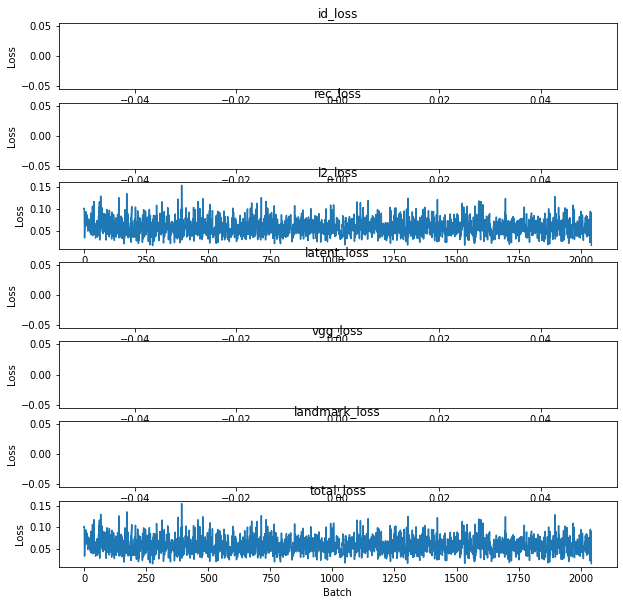

In [ ]:
# 绘制loss曲线
fig, axs = plt.subplots(7, figsize=(10, 10))
axs[0].plot(id_loss_list)
axs[0].set_title('id_loss')
axs[0].set_xlabel('Batch')
axs[0].set_ylabel('Loss')
axs[1].plot(rec_loss_list)
axs[1].set_title('rec_loss')
axs[1].set_xlabel('Batch')
axs[1].set_ylabel('Loss')
axs[2].plot(l2_loss_list)
axs[2].set_title('l2_loss')
axs[2].set_xlabel('Batch')
axs[2].set_ylabel('Loss')
axs[3].plot(latent_loss_list)
axs[3].set_title('latent_loss')
axs[3].set_xlabel('Batch')
axs[3].set_ylabel('Loss')
axs[4].plot(vgg_loss_list)
axs[4].set_title('vgg_loss')
axs[4].set_xlabel('Batch')
axs[4].set_ylabel('Loss')
axs[5].plot(landmark_loss_list)
axs[5].set_title('landmark_loss')
axs[5].set_xlabel('Batch')
axs[5].set_ylabel('Loss')
axs[6].plot(total_loss_list)
axs[6].set_title('total_loss')
axs[6].set_xlabel('Batch')
axs[6].set_ylabel('Loss')
plt.show()

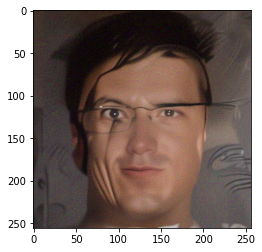

In [ ]:
with torch.no_grad():
    generated_img = model.render(xT_true, semantic_vec.to(device), T=16)
generated_image = generated_img.detach()
plt.imshow(generated_image[0].permute(1, 2, 0).cpu())

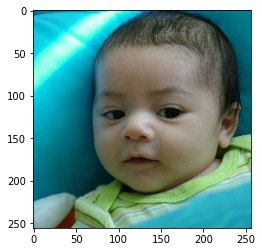

In [ ]:
plt.imshow(attr_images[0].permute(1, 2, 0).cpu())

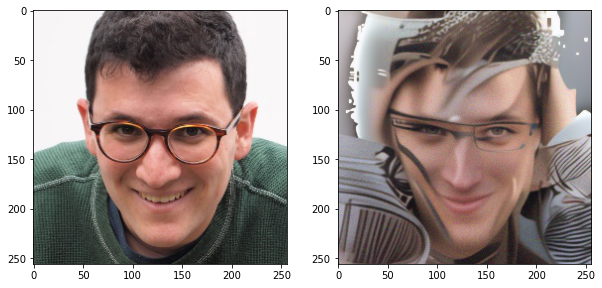

In [ ]:
import matplotlib.pyplot as plt
idn = 4
# torch.manual_seed(1)
for idx, data in enumerate(image_data):
  if idx <idn:
    continue
  if idx == idn:
    batch = data['img'][None]
    torch.cuda.empty_cache()
#         gen_img = batch.detach().clone()
    id_images = batch.cuda()
#         generated_img = Variable(gen_img, requires_grad = True)
#         generated_img = generated_img.cuda()
#         print(generated_img)

    diff_batch = image_data[idx]['img'][None]
    attr_batch = diff_batch*0.5+0.5
    attr_images = attr_batch.cuda()
    with torch.no_grad():
      id_vec = id_encoder.extract_feats(id_images)
      attr_vec = torch.squeeze(attr_encoder(attr_images))[None]
      encoded_vec = torch.cat((id_vec,attr_vec), dim=1)
      semantic_vec = mlp(encoded_vec)
      semantic_vec_true = model.encode(attr_images*2-1)
      xT_true = model.encode_stochastic(attr_images*2-1, semantic_vec_true, T=20)
      ori_img = model.render(xT_true, semantic_vec_true, T=16)
      generated_img = model.render(xT_true, semantic_vec, T=16)

  else:
    break

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
generated_image = generated_img.detach()
ax[0].imshow(attr_images[0].permute(1, 2, 0).cpu())
ax[1].imshow(generated_image[0].permute(1, 2, 0).cpu())

In [ ]:
Model_mlp_path = 'checkpoints/MLP/mlp_ffhq01000_full_attr.pt'
torch.save(mlp, Model_mlp_path)
attr_encoder_path = 'checkpoints/attr/attr_ffhq01000_full_attr.pt'
torch.save(attr_encoder, attr_encoder_path)

tensor([[[[-0.9922, -0.9922, -0.9922,  ..., -0.0902, -0.2471, -0.2314],
          [-0.9922, -0.9922, -0.9922,  ..., -0.2157, -0.2392, -0.3333],
          [-0.9922, -0.9922, -0.9922,  ..., -0.2314, -0.2078, -0.3098],
          ...,
          [ 0.5765,  0.4745,  0.4588,  ...,  0.7098,  0.7020,  0.6941],
          [ 0.6157,  0.6392,  0.5843,  ...,  0.7176,  0.7098,  0.7020],
          [ 0.6314,  0.5843,  0.4667,  ...,  0.7412,  0.7176,  0.7098]],

         [[-0.9922, -0.9922, -0.9922,  ..., -0.2549, -0.3961, -0.4118],
          [-0.9922, -0.9922, -0.9922,  ..., -0.4510, -0.3725, -0.4902],
          [-0.9922, -0.9922, -0.9922,  ..., -0.4902, -0.3490, -0.4745],
          ...,
          [ 0.5451,  0.4118,  0.3961,  ..., -0.4745, -0.4902, -0.4980],
          [ 0.6157,  0.6314,  0.5765,  ..., -0.4667, -0.4588, -0.4824],
          [ 0.6078,  0.5608,  0.4588,  ..., -0.4588, -0.4431, -0.4667]],

         [[-1.0000, -1.0000, -0.9922,  ..., -0.2471, -0.3882, -0.3725],
          [-0.9922, -0.9922, -

In [ ]:
id_images

tensor([[[[-0.9373, -0.9373, -0.9373,  ..., -0.9843, -0.9922, -0.9843],
          [-0.9373, -0.9373, -0.9373,  ..., -0.9843, -0.9843, -0.9843],
          [-0.9294, -0.9294, -0.9294,  ..., -0.9843, -0.9843, -0.9843],
          ...,
          [ 0.4902,  0.5765,  0.6314,  ..., -0.1451, -0.1294, -0.1451],
          [ 0.6549,  0.6078,  0.5843,  ..., -0.1451, -0.1529, -0.1529],
          [ 0.6627,  0.5922,  0.5608,  ..., -0.1608, -0.1529, -0.1451]],

         [[-0.9765, -0.9765, -0.9765,  ..., -0.9843, -0.9922, -0.9843],
          [-0.9765, -0.9765, -0.9765,  ..., -0.9843, -0.9843, -0.9843],
          [-0.9686, -0.9686, -0.9686,  ..., -0.9843, -0.9843, -0.9843],
          ...,
          [-0.1216, -0.0353,  0.0196,  ..., -0.7961, -0.8039, -0.8118],
          [ 0.0431, -0.0039, -0.0275,  ..., -0.7961, -0.8039, -0.7961],
          [ 0.0510, -0.0196, -0.0510,  ..., -0.8118, -0.8039, -0.7882]],

         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -